# Controls Final Project: Quantum Control

## Krystin Albano, Sam Konrad, Andrew Marquardt
### Friday, May 12, 2021

## Abstract 

Quantum control is the method of using light as a catalyst in chemical reactions. More specifically, a shaped laser pulse is directed onto the species in question, and the resultant wavefunction interactions drive the chemical reaction. Here, we model the use of a simple laser to cause the breaking of the bond in a diatomic hydrogen molecule. The laser was modeled as emitting photons at a constant rate, pulsed at different wavelengths in the visible light spectrum. The hydrogen molecule was modeled using a probability model. Our model system successfully returned pulse time values for each wavelength of the laser used for a range of different initial states. 

## Theory
In quantum control, the wavelength of the laser pulsed onto a particle manipulates the particle by interacting with its quantum wavefunction. These systems are steered by a controller which observes how the particle reacts to the laser pulse and adjusts the laser pulse to guide the particle’s activity in the desired direction. Use of feedback control in this manner allows the particle to be manipulated without having to solve the time-dependent Schrodinger equation for the system, which is a likely impossible task. One of the first applications of this theory was done in the late 1990s where Wilson et. al. used a computer-controlled pulse shaper to induce fluorescence in dye molecules. Over the past two decades, more studies have been done in this field. For example, strong-field multiphoton femtosecond photoassociation experiments were able to detect magnesium dimer molecules. This demonstrated coherent control of binary photoreactions under thermal conditions. There have even been biological applications where feedback control was used over energy-flow pathways in the light-harvesting antenna complex in a photosynthetic purple bacteria. This particular study showed that the light field phases were able to connect energy transfer between intra- and intermolecular channels concluding molecular complexity wouldn’t limit control providing possibility for further biological studies.

## General/Common Model Equations

### Photon Energy and Power Rate

The following equations were used to calcuate photon energy, and were encorporated in the optimization routine.

Planck's equation for energy (J) can be found below: 

<center>$ E = h\nu $ [1]<center>

where $h$ is Planck's constant, or $6.626\cdot 10^{-34}$ (Js) and $\nu$ is the frequency ($s^{-1}$).

The relationship between frequency and wavelength can be found below:

<center>$ c=λν $  [2]<center>

where c is the speed of light or $3\cdot 10^{8}$ (m/s) and λ is wavelength (nm).

The equation for Photon rate (photons/s) can be found below: 

<center>Photon rate = Power$\cdot [\frac{hc}{\lambda_{550}}]^{-1}$  [3]<center>

where Power is in Watts.  Power in our simulations was set by default as 1 W in order to simplify the simulations.

### Wavefunction Energy Level Equation
The equation for wavefunction energy can be found below: 

<center>$E_{wf} = \frac{-me^{4}}{8h^{2}\epsilon_{o}^{2}n^{2}}$  [4]<center>

where $m$ is the mass of an electron, or $9.11\cdot 10^{-31}$ (kg), $e$ is the charge of an electron, or $1.602\cdot 10^{-19}$ (C), h is planck's constant, $\epsilon_{o}$ is vacuum permittivity, or $8.854\cdot 10^{-12}$ ($\frac{F}{m}$), and $n$ is the wavefunction energy level.

## Project Goal 
In this project, we will model a two-species system manipulated via quantum control. This was done by creating an optimization code to determine the combination of electromagnetic wavelengths that could be used to break the bond between the two atoms of a diatomic hydrogen molecule, as well as the required pulse time of each wavelength. 

## Model Code
The code below is what is required to run the optimization model.  Two functions exist (Quantum_Control and physical_modeal) to complete the calculation.  Explanations are given above each code block and in the comments in the code themselves.

In [5]:
# import libraries
import numpy as np
import cvxpy as cp
import math
import scipy.optimize 

The cell below is the actual optimization model.  It takes variable physical inputs defining the wavefunction of the molecule, a desired dissociation probability, and an amount of diatomic hydrogen present, and returns the pulse time array and the required energy.  The pulse time array was built to span mainly the visible portion of the electromagnetic spectrum.  It should be noted that our opimization objective changed from our earlier stated objectives due to a variety of difficulties in the execution of the model.  With only the time on minimized, the laser array would spend the minimum amount of time at the most high-energy laser, and the rest of the lasers would be completely off.  This not only defeated the purpose of the optimization, but also provided for very poor graphs.  The other issue was the time scale on which we attempted to optimize.  Because python and cvxpy are incapable of being precise to 15 or more decimal places, the introduction of a molar amount and the change in objective was necessary.  Our model was essentially useless without adjustment for this issue, since the precision of python is about 1000 times less than what we desired.

In [207]:
## cvxpy skeleton function -- this function will take our input quantum model 
## and return an optimized list of pulse times for each wavelength laser in use
# feel free to edit and correct as needed, this is only a VERY rough draft --Sam
def Quantum_Control(physical_inputs,Probability,mol_frac,laser_num=75,min_lambda=380,max_lambda=750):
    # this function is fed the quantum model of the hydrogen molecule, the target dissociation probability,
    # the number of moles of H2 present in the "sample", the number of lasers used, and the minimum and 
    # maximum laser wavelengths in nanometers 
    # the number of lasers is chosen specifically so that the gap between each laser is 5 nm
    #
    # CALCULATION OF REQUIRED ENERGY FROM MODEL
    #
    # unpack physical inputs; this should be a list 4 entries long, and the final 2 entries must be 1, 2, or 3
    weight1 = physical_inputs[0]
    weight2 = physical_inputs[1]
    initial_state1 = physical_inputs[2]
    initial_state2 = physical_inputs[3]
    # run physical model to determine dissociation energy required to break 1 bond
    required_energy = physical_model(weight1,weight2,initial_state1,initial_state2,Probability)
    # determine the total energy input needed given the input amount
    adj_energy = required_energy*(mol_frac*6.022*10**23)
    #
    # CVXPY BUILD
    #
    # define cxvpy variable for time of each laser's pulse
    lambda_grid = np.linspace(min_lambda, max_lambda, laser_num)
    pulse_time = {wavelength: cp.Variable(1, nonneg=True) for wavelength in lambda_grid}
    # physical constants needed for build
    h = 6.626*10**-34 # J*s
    c = 3*10**8
    # note this photon rate was taken as the expected rate of a 550 nm photon, and used as the average rate
    # for all calculations.  Broad band laser application was beyond our understanding, even though it was the 
    # precise method utilized in physical experiments
    photon_rate = 1 / (h * c / (550*10**-9)) # photons / s

    # define cvxpy model
    # objective was to minimize the scatter in wavelength, so as to create a more uniform package
    objective = cp.Minimize(sum(pulse_time[wavelength] - (sum(pulse_time[wavelength] for wavelength in lambda_grid)/laser_num) for wavelength in lambda_grid))
    model = [adj_energy == sum(h*c/(wavelength*10**-9) * photon_rate * pulse_time[wavelength] for wavelength in lambda_grid)]
    problem = cp.Problem(objective, model)
    problem.solve()
    
    # return the pulse times array and the required energy to dissociate the specified amount
    # (note this second value was returned primarily as a sanity check in early and final development of the model)
    return pulse_time,adj_energy

The cell below is the physical model used to compute the required energy to break one diatomic hydrogen molecule bond.  It takes the wavefunction weights and converts these to a valid wavefunction, then extracts the energy value of the molecule by assuming a linear and independent combination of wavefunctions holds.  It also assumes that the wavefunction model energies for the hydrogen electron are an accurate measure of the overall molecular energy.  The first assumption is valid quantum mechanically (see references 4 and 5), but the second is somewhat less valid, if only because we did not factor in any system perturbations or effects from adjacent molecules.  However, we did not find any other more valid ways of modeling the molecular energy, and again it is absolutely valid to assume a linear combination of wavefunctions as the molecular wavefunction.  The function does normalize the wavefunction combination, and provides all of the physical constants it needs to compute energy.

The potential energy barrier, or $V$, is taken from the heat of formation difference between atomistic hydrogen and diatomic hydrogen, and can be found in many literature sources (and is thus not explicitly sourced here).  It is shown below.

<center>$ V = \Delta H^{o}n_{A}$ [5]<center>

Where $H^{o}$ is the enthalpy of formation and $n_{A}$ is Avogadro's number.  We assumed a barrier width of 1 bond length simply as a characteristic length scale of the molecule.  This assumption was informed by the guess that the excitation would occur and the bond would strain, causing it to lengthen.  The probability rule, however, is more precisely from literature (see reference 5).  It takes the energy and width of the potential barrier and the input probability, and solves for the required energy to satisfy these parameters (essentially, what energy would the wavefunction need to be to have that probability of breaking through that barrier?).  The functional form of the probability rule is shown below.

<center>$P = {(1+\frac{V^2\sinh[\frac{w}{h}\sqrt{2m(V-E)}]}{4E(V-E)})}^{-1}$ [6]<center>
    
Where $V$ is the abovementioned potential energy barrier, $w$ is the barrier width, $h$ is reduced planck's constant, and $E$ is the energy of the wavefunction.  Note this equation is only valid if the potential barrier is greater than the energy of the wavefunction, though this is true for all of our simulations.
    
It should also be noted that probability inputs should be restricted on input to between 0.25 and 0.75.  The upper limit on this input is due to the solution method to the probability rule.  Because we are solving for energy required, the solution becomes a nonlinear optimization, and thus scipy.optimize.fsolve was invoked.  However, this solution method was extremely sensitive to the input probability value, unfortunately.  We believe that inputs inside this range still show what we would like to observe in our model solutions, though the model is not perfectly applicable due to this issue.  The lower limit is a physical limit, as the energy required to reach those low proabilities of dissociation is already contained in the starting wavefunction state.  Thus, inputting values below 0.25 will not cause the probability rule to fail, but will cause the cvxpy optimization to fail, as we limited our time values to all be non-negative (and thus provide, not remove, energy).
    
The final step is to find the energy difference between the initial state and the required energy state.  This was done with a tricky adjustment, as the initial solution is positive, but the wavefunction energies are negative.  Thus, the "ground state" was chosen to be the lowest wavefunction energy and was made the "zero" point as a reference value, the calcuated dissocation energy was made negative, and the difference between the energy levels could then be calculated by encorporating the reference value.

In [205]:
# determine the required energy needed to reach an acceptable excited state
# note we will restrict the intitial states to 1 through 3 so that excitation actually is substantial
# if you try to put in something not 1 2 or 3 you will raise an assert error...
def physical_model(weight1,weight2,initial_state1,initial_state2,P):
    #
    # DO NOT INPUT A PROBABILITY BELOW 0.25: VALUE IS TOO SMALL
    # DO NOT INPUT A PROBABILITY ABOVE 0.75: VALUE IS TOO LARGE
    #
    # check if weights are legal (satisfy normalization)
    combo = weight1**2 + weight2**2
    adjustment = math.sqrt(1/combo)
    weight1 = weight1*adjustment
    weight2 = weight2*adjustment
    # acquire current energy of the wavefunction, assuming no perturbation and all ground state right now
    # note all energies involved are negative due to their definitions!
    h = 6.626*10**-34 # J*s
    m = 9.11*10**-31
    e = 1.602*10**-19
    e0 = 8.854*10**-12
    E = -m*e**4/(8*(e0**2)*(h**2))
    E_start = weight1*E/initial_state1 + weight2*E/initial_state2
    # define constants used in dissociation energy equation
    hbar = 6.626*10**(-34)/2/math.pi
    V = 436 # kJ/mol; potential energy barrier
    V = V*1000*6.022*10**(-23) # J/molecule of H2; potential energy barrier
    m_mol = 2*1.6735*10**-27 # kg; mass of H2
    w = 74*10**(-15) #m; potential energy barrier width taken as the bond length of H2
    
    # calculate the required energy given the input probability
    F = lambda x: P - 1/(1+(V**2*np.sinh(w/hbar*math.sqrt(2*m_mol*(V-x))))/(4*x*(V-x)))
    # make this energy negative as well, in order to fit the pattern (helped us visualize the solution procedure)
    E_required = -scipy.optimize.fsolve(F,5*10**-18)
    E_diff = E - E_start - E_required[0]
    # return the energy difference
    return E_diff

## Initial Test
The code below is a test of the routine.  We printed all values and displayed our results to give a quantitative view into exactly what is returned by our code.  This is not very informative, but it does confirm that the code gives an answer that is consistent with the required energy value (in other words, the optimization routine works!).

In [122]:
# parameters used
physical = [1,1,3,3]
P = 0.5
mol_frac = 0.001

In [212]:
# model execution
pulse_time,required_energy = Quantum_Control(physical,P,mol_frac)
# display energy calculated by physical_model
print(required_energy)
# print each value of the laser array that is actually turned on
for k in pulse_time.keys():
    j = pulse_time[k].value
    if j[0] != 0:
        print(str(k) + ":" + str(j))
# check if the total energy from the individual lasers is consistent with the model-calculated value
total_energy = 0
h = 6.626*10**-34 # J*s
c = 3*10**8
photon_rate = 1 / (h * c / (550*10**-9))
for k in pulse_time.keys():
    total_energy += h*c/(k*10**(-9))*photon_rate*pulse_time[k].value
# print sanity check
print(total_energy)

1478.5214668359713
380.0:[21.90887059]
385.0:[21.90896216]
390.0:[21.90905325]
395.0:[21.90914386]
400.0:[21.90923401]
405.0:[21.90932369]
410.0:[21.90941293]
415.0:[21.90950173]
420.0:[21.90959009]
425.0:[21.90967801]
430.0:[21.90976555]
435.0:[21.90985346]
440.0:[21.9099409]
445.0:[21.91002789]
450.0:[21.91011443]
455.0:[21.91020052]
460.0:[21.84269332]
465.0:[21.72506926]
470.0:[21.60932763]
475.0:[21.49541875]
480.0:[21.38329477]
485.0:[21.27290956]
490.0:[21.16421865]
495.0:[21.05717914]
500.0:[20.95174963]
505.0:[20.84789019]
510.0:[20.74556221]
515.0:[20.64472845]
520.0:[20.54535288]
525.0:[20.44740072]
530.0:[20.35083828]
535.0:[20.25563306]
540.0:[20.16175352]
545.0:[20.06916921]
550.0:[19.97785061]
555.0:[19.79801944]
560.0:[19.62139962]
565.0:[19.44790592]
570.0:[19.27745606]
575.0:[19.10997062]
580.0:[18.94537296]
585.0:[18.78358902]
590.0:[18.62454725]
595.0:[18.46817855]
600.0:[18.31441606]
605.0:[18.16319518]
610.0:[18.01445341]
615.0:[17.86813028]
620.0:[17.72416727]
62

It can be seen that to a reasonable precision, the sum of energy from the laser array is consistent with the required energy calculated by the model.

## Analysis of Model Predictions and Variance of Parameters

The following cells demonstrate varying parameters of the model, and model response.  For each of these simulations, the number of moles of diatomic hydrogen put through the model is held consistent at 1 mM.

In [213]:
mol_frac = 0.001

The following model shows a simple variance, that of the initial wavefunctions of the linear combination.  The weights are kept at 1 each, meaning each state is equally important to the initial energy.  The code below samples the model 6 times, for each unique combination of valid wavefunctions.  The probability was held constant at 0.75.  It can be seen that the overall time of laser application decreases as the initial states increase, showing that the energy required lessens.  This is physically expected.

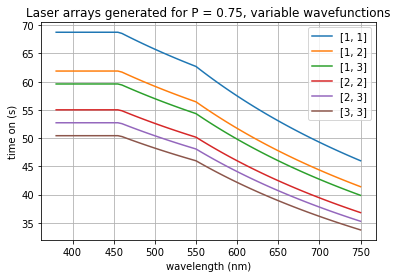

In [208]:
# initial conditions
wf_list = [[1,1],[1,2],[1,3],[2,2],[2,3],[3,3]]
P = 0.75
# solve the model for each wavefunction combination
for combo in wf_list:
    physical = [1,1,combo[0],combo[1]]
    pulse_time,required_energy = Quantum_Control(physical,P,mol_frac)
    # initialize lists to build plottable datasets
    wavelength = []
    time = []
    for k in pulse_time.keys():
        wavelength.append(k)
        time.append(pulse_time[k].value)
    # plot the results on one graph
    plt.plot(wavelength,time,label=combo)
    plt.xlabel("wavelength (nm)")
    plt.ylabel("time on (s)")
    plt.title("Laser arrays generated for P = 0.75, variable wavefunctions")
    plt.grid(True)
    plt.legend()

The next model shows the effects of increasing the probability of dissociation.  Probability was sampled between the acceptable values for our model every and incremented every 5%.  The physical model was held constant at wavefunction energy level 3 for both functions of the linear combination.  It can be seen that increasing the probability of dissociation increases the laser application time, showing an increase in applied energy. Again, this is expected.

The following model holds probability and the wavefunctions of the linear combination constant, but randomizes the weights.  Because the energy levels are identical across all simulations, it would be expected that all curves would be identical.  However, they are not identical, due to rounding variance in python.  The overall model variance can be calculated from this experiment, and while this calculation was not completed in this model, the experiment shows that it is not completely negligible and should at least be considered in overall evaluation. 

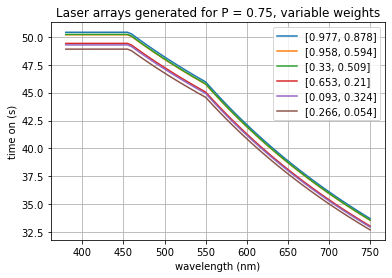

In [210]:
P = 0.75
num_sim = 6
for sims in range(num_sim):
    weight1 = round(np.random.rand(1)[0],3)
    weight2 = round(np.random.rand(1)[0],3)
    physical = [weight1,weight2,3,3]
    pulse_time,required_energy = Quantum_Control(physical,P,mol_frac)
    wavelength = []
    time = []
    for k in pulse_time.keys():
        wavelength.append(k)
        time.append(pulse_time[k].value)
    plt.plot(wavelength,time,label=[weight1,weight2])
    plt.xlabel("wavelength (nm)")
    plt.ylabel("time on (s)")
    plt.title("Laser arrays generated for P = 0.75, variable weights")
    plt.grid(True)
    plt.legend()

This final simulation varies all of the above parameters to create a final evaluation of the effects of changing parameters.  The 5 graphs are aggregated by shared dissociation probability.  The physical constants, both weights and the wavefunctions, were determined with random number generators (or in the case of the wavefunctions, a random choice from the 3 possible options).  The results, labeled by their physical parameter set, are displayed in each graph.  It is observed that variance in the overall magnitude of time required is dependent on all three types of parameters, though it is consistently proportional to magnitude of probability.  The wavefunction combination is important as well, however, and this is shown on each graph as the simulations where state 3 is more important tend to be require less laser time and energy and the simulations where state 1 is more important tend to require more laser time and energy.

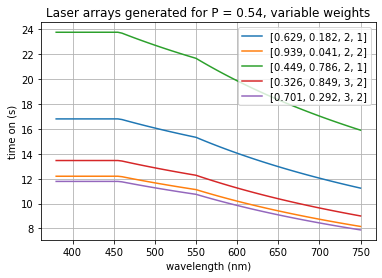

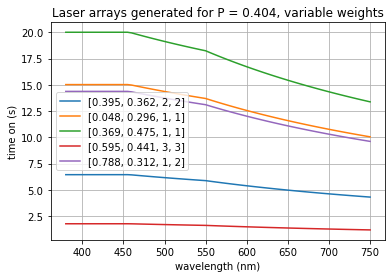

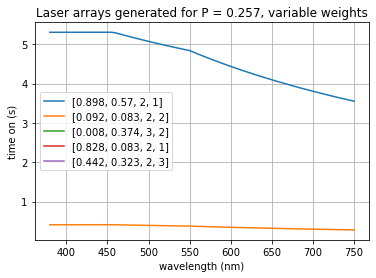

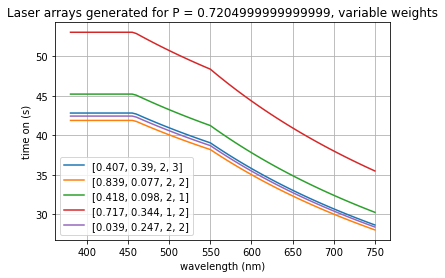

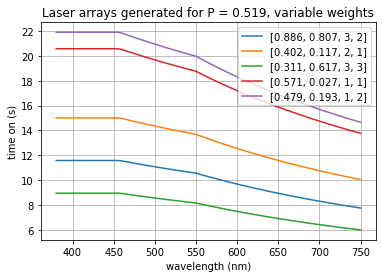

In [211]:
# Final dump!!!
import random
num_graphs = 5
num_sims = 5
wf_choices = [1,2,3]
for graphs in range(num_graphs):
    P = 0.5*round(np.random.rand(1)[0],3) + 0.25
    for sims in range(num_sims):
        weight1 = round(np.random.rand(1)[0],3)
        weight2 = round(np.random.rand(1)[0],3)
        wf1 = random.sample(wf_choices,1)[0]
        wf2 = random.sample(wf_choices,1)[0]
        physical = [weight1,weight2,wf1,wf2]
        pulse_time,required_energy = Quantum_Control(physical,P,mol_frac)
        wavelength = []
        time = []
        for k in pulse_time.keys():
            wavelength.append(k)
            time.append(pulse_time[k].value)
        plt.plot(wavelength,time,label=physical)
        plt.xlabel("wavelength (nm)")
        plt.ylabel("time on (s)")
        plt.title("Laser arrays generated for P = " + str(P) + ", variable weights")
        plt.grid(True)
        plt.legend()
    plt.show()

## Final Notes
We were not able to accomplish our initially stated objective of building a wavepacket to form a bond.  In hindsight, this was probably too ambitious of a goal, as it was difficult enough to find the required equations and model concepts to build the current project and we were unable to find any relevant literature on building bonds.

Some simplifications were made as well, especially in deviating from the initial motivation for this project and from a perfectly physical model.  Many of these are detailed above, but we would like to emphasize that they do exist and thus we are not certain whether the concepts or results of this simulation are applicable to any real experiment.  However, as an interesting problem combining Physical Chemistry with an optimization model that utilizes an entire laser array to communicate a certain amount of energy that would raise the probability of dissociation, it is a fascinating problem to consider.  Furthermore, the ability to vary multiple parameters makes for an interesting exploration into the results of the model.

## Sources 


1.  Durrani, Jamie. (2020, September 28).  How lasers could replace chemical reagents - for a price. Chemistryworld. https://www.chemistryworld.com/holy-grails/the-grails/quantum-control 
2. Wilson, Kent R., et. al. (1997). Feedback quantum control of molecular electronic population transfer. Chemical Physics Letters, 280, 151-158. https://doi.org/10.1016/S0009-2614(97)01081-6
3. Kosloff, Ronnie, et. al. (2015). Coherent Control of Bond Making. Physical Review Letters, 114(23), 233033. https://doi.org/10.1103/PhysRevLett.114.233003 
4. University of Massachusetts Boston. Quantum Mechanical Approaches to Molecular Bonding. http://alpha.chem.umb.edu/chemistry/ch612/documents/VBTheory.pdf 
5. Smith, Kevin, et. al. (2017). Simulations in quantum tunneling. American Journal of Physics, 85, 763. https://doi.org/10.1119/1.4991367